<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:09:20] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


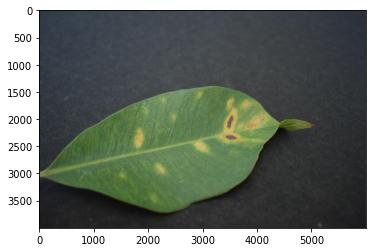

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

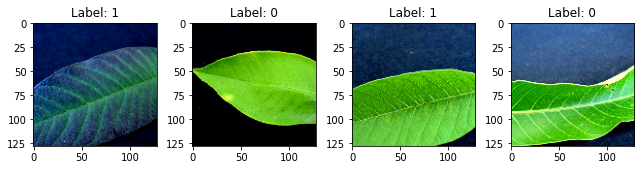

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:09:26] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:09:28] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2574366146407747 samples/sec                   batch loss = 0.7940624952316284 | accuracy = 0.25


Epoch[1] Batch[10] Speed: 1.2709383391867053 samples/sec                   batch loss = 1.0688351392745972 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2717218545054318 samples/sec                   batch loss = 0.38753652572631836 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.258494730060219 samples/sec                   batch loss = 0.4814877212047577 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.2591476722466621 samples/sec                   batch loss = 0.45169639587402344 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.272202093794597 samples/sec                   batch loss = 0.9732640385627747 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2715260055816977 samples/sec                   batch loss = 0.309953898191452 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.274710232622315 samples/sec                   batch loss = 0.5285382866859436 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.2750061803983224 samples/sec                   batch loss = 0.20963607728481293 | accuracy = 0.6222222222222222


Epoch[1] Batch[50] Speed: 1.2746309167826473 samples/sec                   batch loss = 0.4861006736755371 | accuracy = 0.62


Epoch[1] Batch[55] Speed: 1.2649921162381366 samples/sec                   batch loss = 0.8565232753753662 | accuracy = 0.6318181818181818


Epoch[1] Batch[60] Speed: 1.2738780533917886 samples/sec                   batch loss = 0.7311171293258667 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.2828959904912303 samples/sec                   batch loss = 0.21240723133087158 | accuracy = 0.6384615384615384


Epoch[1] Batch[70] Speed: 1.2722933609694815 samples/sec                   batch loss = 0.4084668755531311 | accuracy = 0.6428571428571429


Epoch[1] Batch[75] Speed: 1.2704694436608919 samples/sec                   batch loss = 0.456585168838501 | accuracy = 0.6533333333333333


Epoch[1] Batch[80] Speed: 1.2716641152103607 samples/sec                   batch loss = 0.6219610571861267 | accuracy = 0.64375


Epoch[1] Batch[85] Speed: 1.2731163212822516 samples/sec                   batch loss = 0.4644789397716522 | accuracy = 0.65


Epoch[1] Batch[90] Speed: 1.2728932908530173 samples/sec                   batch loss = 0.5120633244514465 | accuracy = 0.65


Epoch[1] Batch[95] Speed: 1.269044864095494 samples/sec                   batch loss = 0.281864732503891 | accuracy = 0.6552631578947369


Epoch[1] Batch[100] Speed: 1.2700718466691683 samples/sec                   batch loss = 0.9718583822250366 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.2773794969715828 samples/sec                   batch loss = 0.5521900653839111 | accuracy = 0.6452380952380953


Epoch[1] Batch[110] Speed: 1.2733146898641676 samples/sec                   batch loss = 0.3608434498310089 | accuracy = 0.65


Epoch[1] Batch[115] Speed: 1.2737396558859384 samples/sec                   batch loss = 0.520672082901001 | accuracy = 0.6478260869565218


Epoch[1] Batch[120] Speed: 1.2746245254597597 samples/sec                   batch loss = 0.17127487063407898 | accuracy = 0.6479166666666667


Epoch[1] Batch[125] Speed: 1.2692626108131733 samples/sec                   batch loss = 0.5773603916168213 | accuracy = 0.65


Epoch[1] Batch[130] Speed: 1.2710385729519929 samples/sec                   batch loss = 0.2894364893436432 | accuracy = 0.6519230769230769


Epoch[1] Batch[135] Speed: 1.2715174289319429 samples/sec                   batch loss = 0.3620149791240692 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.2753431759338232 samples/sec                   batch loss = 0.6408013105392456 | accuracy = 0.6589285714285714


Epoch[1] Batch[145] Speed: 1.2715437374491905 samples/sec                   batch loss = 0.3295544981956482 | accuracy = 0.6620689655172414


Epoch[1] Batch[150] Speed: 1.2775928167570014 samples/sec                   batch loss = 0.5352945923805237 | accuracy = 0.6666666666666666


Epoch[1] Batch[155] Speed: 1.2712568117862486 samples/sec                   batch loss = 0.4414992928504944 | accuracy = 0.6693548387096774


Epoch[1] Batch[160] Speed: 1.271638476403137 samples/sec                   batch loss = 0.4501643478870392 | accuracy = 0.671875


Epoch[1] Batch[165] Speed: 1.2705200507777397 samples/sec                   batch loss = 0.668231725692749 | accuracy = 0.6712121212121213


Epoch[1] Batch[170] Speed: 1.2752275286892096 samples/sec                   batch loss = 1.1437621116638184 | accuracy = 0.6735294117647059


Epoch[1] Batch[175] Speed: 1.270347560558234 samples/sec                   batch loss = 0.611000657081604 | accuracy = 0.67


Epoch[1] Batch[180] Speed: 1.2752018429192282 samples/sec                   batch loss = 0.48823100328445435 | accuracy = 0.6680555555555555


Epoch[1] Batch[185] Speed: 1.2731235669766152 samples/sec                   batch loss = 0.932372510433197 | accuracy = 0.6702702702702703


Epoch[1] Batch[190] Speed: 1.273651371862088 samples/sec                   batch loss = 0.6062335968017578 | accuracy = 0.6736842105263158


Epoch[1] Batch[195] Speed: 1.269005700656929 samples/sec                   batch loss = 0.3887603282928467 | accuracy = 0.6794871794871795


Epoch[1] Batch[200] Speed: 1.2687928397353847 samples/sec                   batch loss = 0.4974852204322815 | accuracy = 0.67875


Epoch[1] Batch[205] Speed: 1.2800713907002716 samples/sec                   batch loss = 0.5490696430206299 | accuracy = 0.6780487804878049


Epoch[1] Batch[210] Speed: 1.2725171463732363 samples/sec                   batch loss = 0.7076871395111084 | accuracy = 0.6761904761904762


Epoch[1] Batch[215] Speed: 1.2750255598408826 samples/sec                   batch loss = 0.611343264579773 | accuracy = 0.6790697674418604


Epoch[1] Batch[220] Speed: 1.274111975814891 samples/sec                   batch loss = 0.5414904952049255 | accuracy = 0.6772727272727272


Epoch[1] Batch[225] Speed: 1.269380732218287 samples/sec                   batch loss = 0.5400236248970032 | accuracy = 0.6766666666666666


Epoch[1] Batch[230] Speed: 1.2683131569032178 samples/sec                   batch loss = 0.3201870620250702 | accuracy = 0.6793478260869565


Epoch[1] Batch[235] Speed: 1.2673956634882342 samples/sec                   batch loss = 0.1323586404323578 | accuracy = 0.6829787234042554


Epoch[1] Batch[240] Speed: 1.2711633817526418 samples/sec                   batch loss = 0.540943443775177 | accuracy = 0.6864583333333333


Epoch[1] Batch[245] Speed: 1.267584878814492 samples/sec                   batch loss = 0.6927821636199951 | accuracy = 0.6826530612244898


Epoch[1] Batch[250] Speed: 1.2713516043285262 samples/sec                   batch loss = 0.413900762796402 | accuracy = 0.683


Epoch[1] Batch[255] Speed: 1.2698722764269794 samples/sec                   batch loss = 0.8996418714523315 | accuracy = 0.6833333333333333


Epoch[1] Batch[260] Speed: 1.2684651466904313 samples/sec                   batch loss = 0.612801194190979 | accuracy = 0.6817307692307693


Epoch[1] Batch[265] Speed: 1.2707336841736123 samples/sec                   batch loss = 1.002706527709961 | accuracy = 0.6830188679245283


Epoch[1] Batch[270] Speed: 1.2721284914366922 samples/sec                   batch loss = 0.5877642035484314 | accuracy = 0.6814814814814815


Epoch[1] Batch[275] Speed: 1.2703523700243406 samples/sec                   batch loss = 0.9077550768852234 | accuracy = 0.6818181818181818


Epoch[1] Batch[280] Speed: 1.273108012987553 samples/sec                   batch loss = 0.4818311929702759 | accuracy = 0.6821428571428572


Epoch[1] Batch[285] Speed: 1.2702033896739555 samples/sec                   batch loss = 0.7151559591293335 | accuracy = 0.6815789473684211


Epoch[1] Batch[290] Speed: 1.2701361724098512 samples/sec                   batch loss = 0.6540106534957886 | accuracy = 0.6810344827586207


Epoch[1] Batch[295] Speed: 1.2736035121459157 samples/sec                   batch loss = 0.4892415404319763 | accuracy = 0.6813559322033899


Epoch[1] Batch[300] Speed: 1.2753768174189737 samples/sec                   batch loss = 0.980050265789032 | accuracy = 0.6841666666666667


Epoch[1] Batch[305] Speed: 1.2793345258485995 samples/sec                   batch loss = 0.2966547906398773 | accuracy = 0.6868852459016394


Epoch[1] Batch[310] Speed: 1.2718630920726204 samples/sec                   batch loss = 0.7482250332832336 | accuracy = 0.6870967741935484


Epoch[1] Batch[315] Speed: 1.2719521891025949 samples/sec                   batch loss = 0.3890737295150757 | accuracy = 0.6896825396825397


Epoch[1] Batch[320] Speed: 1.2763584365772824 samples/sec                   batch loss = 1.4074026346206665 | accuracy = 0.68984375


Epoch[1] Batch[325] Speed: 1.2731810524079106 samples/sec                   batch loss = 0.7779210209846497 | accuracy = 0.69


Epoch[1] Batch[330] Speed: 1.2818045913791443 samples/sec                   batch loss = 0.8509698510169983 | accuracy = 0.6901515151515152


Epoch[1] Batch[335] Speed: 1.2731534201072936 samples/sec                   batch loss = 0.7751867771148682 | accuracy = 0.6895522388059702


Epoch[1] Batch[340] Speed: 1.2749947468035296 samples/sec                   batch loss = 0.5187838077545166 | accuracy = 0.6919117647058823


Epoch[1] Batch[345] Speed: 1.271621320184699 samples/sec                   batch loss = 0.8784759044647217 | accuracy = 0.6920289855072463


Epoch[1] Batch[350] Speed: 1.2690999657709756 samples/sec                   batch loss = 0.8429660201072693 | accuracy = 0.6892857142857143


Epoch[1] Batch[355] Speed: 1.2688640413461176 samples/sec                   batch loss = 0.417860209941864 | accuracy = 0.6901408450704225


Epoch[1] Batch[360] Speed: 1.2691266543651396 samples/sec                   batch loss = 0.28425711393356323 | accuracy = 0.6895833333333333


Epoch[1] Batch[365] Speed: 1.25950129735897 samples/sec                   batch loss = 0.5886843204498291 | accuracy = 0.6904109589041096


Epoch[1] Batch[370] Speed: 1.2690074284047208 samples/sec                   batch loss = 1.1021723747253418 | accuracy = 0.6905405405405406


Epoch[1] Batch[375] Speed: 1.2681389648348995 samples/sec                   batch loss = 0.4243987500667572 | accuracy = 0.69


Epoch[1] Batch[380] Speed: 1.266145543960125 samples/sec                   batch loss = 0.9148587584495544 | accuracy = 0.6907894736842105


Epoch[1] Batch[385] Speed: 1.2661179295521643 samples/sec                   batch loss = 0.37385499477386475 | accuracy = 0.6902597402597402


Epoch[1] Batch[390] Speed: 1.2657822576233975 samples/sec                   batch loss = 1.1641597747802734 | accuracy = 0.6891025641025641


Epoch[1] Batch[395] Speed: 1.2672972478921456 samples/sec                   batch loss = 0.45651116967201233 | accuracy = 0.689873417721519


Epoch[1] Batch[400] Speed: 1.2701750210052765 samples/sec                   batch loss = 0.2897789478302002 | accuracy = 0.690625


Epoch[1] Batch[405] Speed: 1.2660276417129797 samples/sec                   batch loss = 0.6310288310050964 | accuracy = 0.6907407407407408


Epoch[1] Batch[410] Speed: 1.2632074137732936 samples/sec                   batch loss = 0.6076409220695496 | accuracy = 0.6902439024390243


Epoch[1] Batch[415] Speed: 1.2669004855948842 samples/sec                   batch loss = 0.5574315786361694 | accuracy = 0.6909638554216867


Epoch[1] Batch[420] Speed: 1.2680731160169547 samples/sec                   batch loss = 0.43256115913391113 | accuracy = 0.6904761904761905


Epoch[1] Batch[425] Speed: 1.2685220203726082 samples/sec                   batch loss = 1.0751668214797974 | accuracy = 0.69


Epoch[1] Batch[430] Speed: 1.2617337775252888 samples/sec                   batch loss = 0.47628140449523926 | accuracy = 0.6901162790697675


Epoch[1] Batch[435] Speed: 1.2654520133077043 samples/sec                   batch loss = 0.35799679160118103 | accuracy = 0.6873563218390805


Epoch[1] Batch[440] Speed: 1.2659018334703698 samples/sec                   batch loss = 0.5057989358901978 | accuracy = 0.6880681818181819


Epoch[1] Batch[445] Speed: 1.2648704235078763 samples/sec                   batch loss = 0.7609390616416931 | accuracy = 0.6882022471910112


Epoch[1] Batch[450] Speed: 1.2716029114988805 samples/sec                   batch loss = 0.23044805228710175 | accuracy = 0.6911111111111111


Epoch[1] Batch[455] Speed: 1.2682953232656207 samples/sec                   batch loss = 0.8379260897636414 | accuracy = 0.6912087912087912


Epoch[1] Batch[460] Speed: 1.2757186651122316 samples/sec                   batch loss = 0.8432517647743225 | accuracy = 0.6923913043478261


Epoch[1] Batch[465] Speed: 1.2691479676457293 samples/sec                   batch loss = 0.5963436961174011 | accuracy = 0.6935483870967742


Epoch[1] Batch[470] Speed: 1.2699526353202761 samples/sec                   batch loss = 1.1367924213409424 | accuracy = 0.6941489361702128


Epoch[1] Batch[475] Speed: 1.2747862650063937 samples/sec                   batch loss = 0.804818868637085 | accuracy = 0.6936842105263158


Epoch[1] Batch[480] Speed: 1.2728717550230255 samples/sec                   batch loss = 0.5735654234886169 | accuracy = 0.69375


Epoch[1] Batch[485] Speed: 1.2789760151441252 samples/sec                   batch loss = 0.5379432439804077 | accuracy = 0.6932989690721649


Epoch[1] Batch[490] Speed: 1.2751072506664263 samples/sec                   batch loss = 0.20455245673656464 | accuracy = 0.6938775510204082


Epoch[1] Batch[495] Speed: 1.2681571775056288 samples/sec                   batch loss = 0.4693700075149536 | accuracy = 0.693939393939394


Epoch[1] Batch[500] Speed: 1.266008534826596 samples/sec                   batch loss = 0.7585787773132324 | accuracy = 0.6945


Epoch[1] Batch[505] Speed: 1.2674649848135822 samples/sec                   batch loss = 0.5812090039253235 | accuracy = 0.6955445544554455


Epoch[1] Batch[510] Speed: 1.2676892778457736 samples/sec                   batch loss = 0.17039400339126587 | accuracy = 0.6965686274509804


Epoch[1] Batch[515] Speed: 1.2643624472080648 samples/sec                   batch loss = 0.18548455834388733 | accuracy = 0.6980582524271844


Epoch[1] Batch[520] Speed: 1.2662206535990332 samples/sec                   batch loss = 1.0689212083816528 | accuracy = 0.6985576923076923


Epoch[1] Batch[525] Speed: 1.2394237924490905 samples/sec                   batch loss = 0.6531122326850891 | accuracy = 0.6980952380952381


Epoch[1] Batch[530] Speed: 1.2688387072426637 samples/sec                   batch loss = 0.3229060173034668 | accuracy = 0.6985849056603773


Epoch[1] Batch[535] Speed: 1.2704868574419568 samples/sec                   batch loss = 0.32073041796684265 | accuracy = 0.6995327102803738


Epoch[1] Batch[540] Speed: 1.2722154067950608 samples/sec                   batch loss = 0.6499334573745728 | accuracy = 0.6986111111111111


Epoch[1] Batch[545] Speed: 1.2696381785887287 samples/sec                   batch loss = 0.6669274568557739 | accuracy = 0.6990825688073394


Epoch[1] Batch[550] Speed: 1.273199410193812 samples/sec                   batch loss = 0.4095751941204071 | accuracy = 0.6977272727272728


Epoch[1] Batch[555] Speed: 1.2679147043035315 samples/sec                   batch loss = 0.4491584002971649 | accuracy = 0.6977477477477477


Epoch[1] Batch[560] Speed: 1.2704303846506544 samples/sec                   batch loss = 0.33618199825286865 | accuracy = 0.6977678571428572


Epoch[1] Batch[565] Speed: 1.266784738313444 samples/sec                   batch loss = 0.4605650007724762 | accuracy = 0.6964601769911505


Epoch[1] Batch[570] Speed: 1.2687872744475492 samples/sec                   batch loss = 0.7434649467468262 | accuracy = 0.6960526315789474


Epoch[1] Batch[575] Speed: 1.2732018257313682 samples/sec                   batch loss = 0.8196679353713989 | accuracy = 0.6965217391304348


Epoch[1] Batch[580] Speed: 1.2690679985367745 samples/sec                   batch loss = 0.21332797408103943 | accuracy = 0.6978448275862069


Epoch[1] Batch[585] Speed: 1.2660391061216432 samples/sec                   batch loss = 0.3570514917373657 | accuracy = 0.6995726495726495


Epoch[1] Batch[590] Speed: 1.271541520938708 samples/sec                   batch loss = 0.3561263680458069 | accuracy = 0.6995762711864407


Epoch[1] Batch[595] Speed: 1.2670723280011298 samples/sec                   batch loss = 0.5026015043258667 | accuracy = 0.7012605042016806


Epoch[1] Batch[600] Speed: 1.2706782480664953 samples/sec                   batch loss = 0.2436918020248413 | accuracy = 0.7020833333333333


Epoch[1] Batch[605] Speed: 1.2722331578957746 samples/sec                   batch loss = 0.7495647668838501 | accuracy = 0.7020661157024793


Epoch[1] Batch[610] Speed: 1.2729482443221867 samples/sec                   batch loss = 0.8446136116981506 | accuracy = 0.7020491803278689


Epoch[1] Batch[615] Speed: 1.2693895681989813 samples/sec                   batch loss = 0.5723508596420288 | accuracy = 0.7016260162601626


Epoch[1] Batch[620] Speed: 1.2716351993368815 samples/sec                   batch loss = 0.5827874541282654 | accuracy = 0.7024193548387097


Epoch[1] Batch[625] Speed: 1.2693313682417033 samples/sec                   batch loss = 0.4293380677700043 | accuracy = 0.7024


Epoch[1] Batch[630] Speed: 1.270669586611676 samples/sec                   batch loss = 0.392806738615036 | accuracy = 0.7015873015873015


Epoch[1] Batch[635] Speed: 1.2714506506618173 samples/sec                   batch loss = 0.8022522330284119 | accuracy = 0.7019685039370078


Epoch[1] Batch[640] Speed: 1.2639194332362007 samples/sec                   batch loss = 0.6847997903823853 | accuracy = 0.701953125


Epoch[1] Batch[645] Speed: 1.2677880417472231 samples/sec                   batch loss = 1.0821894407272339 | accuracy = 0.7015503875968992


Epoch[1] Batch[650] Speed: 1.2702202191440475 samples/sec                   batch loss = 0.7227783203125 | accuracy = 0.7011538461538461


Epoch[1] Batch[655] Speed: 1.2676424398232713 samples/sec                   batch loss = 0.587364137172699 | accuracy = 0.7011450381679389


Epoch[1] Batch[660] Speed: 1.273160666223946 samples/sec                   batch loss = 0.7265381813049316 | accuracy = 0.7018939393939394


Epoch[1] Batch[665] Speed: 1.2718946217373295 samples/sec                   batch loss = 0.23531243205070496 | accuracy = 0.7030075187969925


Epoch[1] Batch[670] Speed: 1.2753940751231418 samples/sec                   batch loss = 0.4086899161338806 | accuracy = 0.7037313432835821


Epoch[1] Batch[675] Speed: 1.271872541165891 samples/sec                   batch loss = 0.4305744767189026 | accuracy = 0.7040740740740741


Epoch[1] Batch[680] Speed: 1.2720079293058681 samples/sec                   batch loss = 0.42047837376594543 | accuracy = 0.7044117647058824


Epoch[1] Batch[685] Speed: 1.2685188552613442 samples/sec                   batch loss = 0.5993557572364807 | accuracy = 0.7047445255474453


Epoch[1] Batch[690] Speed: 1.2649874426523664 samples/sec                   batch loss = 0.7663061022758484 | accuracy = 0.7043478260869566


Epoch[1] Batch[695] Speed: 1.2651082039291672 samples/sec                   batch loss = 0.1703709214925766 | accuracy = 0.7050359712230215


Epoch[1] Batch[700] Speed: 1.2739577592421685 samples/sec                   batch loss = 0.6424362659454346 | accuracy = 0.7057142857142857


Epoch[1] Batch[705] Speed: 1.2664585595893276 samples/sec                   batch loss = 0.48698872327804565 | accuracy = 0.7056737588652482


Epoch[1] Batch[710] Speed: 1.2737749535807368 samples/sec                   batch loss = 0.4133562445640564 | accuracy = 0.7059859154929577


Epoch[1] Batch[715] Speed: 1.2690540793735188 samples/sec                   batch loss = 0.6689686179161072 | accuracy = 0.7055944055944056


Epoch[1] Batch[720] Speed: 1.26362832376969 samples/sec                   batch loss = 0.595203697681427 | accuracy = 0.7065972222222222


Epoch[1] Batch[725] Speed: 1.2697559855126923 samples/sec                   batch loss = 0.1182200163602829 | accuracy = 0.7062068965517241


Epoch[1] Batch[730] Speed: 1.27007973078926 samples/sec                   batch loss = 0.3296480178833008 | accuracy = 0.7065068493150685


Epoch[1] Batch[735] Speed: 1.2694785111161742 samples/sec                   batch loss = 0.5018879175186157 | accuracy = 0.7071428571428572


Epoch[1] Batch[740] Speed: 1.2685483969140579 samples/sec                   batch loss = 0.7746015787124634 | accuracy = 0.7081081081081081


Epoch[1] Batch[745] Speed: 1.271984494680585 samples/sec                   batch loss = 0.7836724519729614 | accuracy = 0.7053691275167785


Epoch[1] Batch[750] Speed: 1.2661564371720693 samples/sec                   batch loss = 0.4748881161212921 | accuracy = 0.7053333333333334


Epoch[1] Batch[755] Speed: 1.2692252582938872 samples/sec                   batch loss = 0.5191017389297485 | accuracy = 0.704635761589404


Epoch[1] Batch[760] Speed: 1.2642897491437877 samples/sec                   batch loss = 0.3333619236946106 | accuracy = 0.7049342105263158


Epoch[1] Batch[765] Speed: 1.268404442299341 samples/sec                   batch loss = 0.3660999536514282 | accuracy = 0.7058823529411765


Epoch[1] Batch[770] Speed: 1.2747354143182468 samples/sec                   batch loss = 0.8940210342407227 | accuracy = 0.7055194805194805


Epoch[1] Batch[775] Speed: 1.272141802896764 samples/sec                   batch loss = 0.4827314615249634 | accuracy = 0.7041935483870968


Epoch[1] Batch[780] Speed: 1.2694792795758116 samples/sec                   batch loss = 0.5323882102966309 | accuracy = 0.7041666666666667


Epoch[1] Batch[785] Speed: 1.2699118778641625 samples/sec                   batch loss = 0.5340126156806946 | accuracy = 0.7044585987261146


[Epoch 1] training: accuracy=0.7046319796954315
[Epoch 1] time cost: 647.2873487472534
[Epoch 1] validation: validation accuracy=0.7722222222222223


Epoch[2] Batch[5] Speed: 1.2664594199981913 samples/sec                   batch loss = 0.4081787168979645 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2774603224881442 samples/sec                   batch loss = 0.947080671787262 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2719843018065933 samples/sec                   batch loss = 0.4199483394622803 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2676795076658223 samples/sec                   batch loss = 0.47107329964637756 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2691417271966678 samples/sec                   batch loss = 0.5553333759307861 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2695746718535657 samples/sec                   batch loss = 0.22068476676940918 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2689016605176238 samples/sec                   batch loss = 0.9759480357170105 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2737662498578353 samples/sec                   batch loss = 0.534616231918335 | accuracy = 0.70625


Epoch[2] Batch[45] Speed: 1.2810542856276752 samples/sec                   batch loss = 0.5473589301109314 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2703090861403392 samples/sec                   batch loss = 0.4695848822593689 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.2711379557497853 samples/sec                   batch loss = 0.5233858227729797 | accuracy = 0.7136363636363636


Epoch[2] Batch[60] Speed: 1.2759451127832129 samples/sec                   batch loss = 1.320076584815979 | accuracy = 0.7166666666666667


Epoch[2] Batch[65] Speed: 1.2694415300958262 samples/sec                   batch loss = 0.6053939461708069 | accuracy = 0.7115384615384616


Epoch[2] Batch[70] Speed: 1.2748002133327174 samples/sec                   batch loss = 0.7173113822937012 | accuracy = 0.7178571428571429


Epoch[2] Batch[75] Speed: 1.2734318268847242 samples/sec                   batch loss = 0.7743260860443115 | accuracy = 0.7233333333333334


Epoch[2] Batch[80] Speed: 1.265827143671455 samples/sec                   batch loss = 0.16472209990024567 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2732341948189438 samples/sec                   batch loss = 0.5189661979675293 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2721208712334842 samples/sec                   batch loss = 0.5608070492744446 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2692569453796072 samples/sec                   batch loss = 0.5444833040237427 | accuracy = 0.75


Epoch[2] Batch[100] Speed: 1.2705521874277008 samples/sec                   batch loss = 0.5149106383323669 | accuracy = 0.7475


Epoch[2] Batch[105] Speed: 1.2730058105134343 samples/sec                   batch loss = 0.3161298334598541 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2729582890543993 samples/sec                   batch loss = 0.5247414112091064 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.2693607556718933 samples/sec                   batch loss = 1.1948734521865845 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2671447722019946 samples/sec                   batch loss = 0.29954031109809875 | accuracy = 0.7354166666666667


Epoch[2] Batch[125] Speed: 1.2712427482433784 samples/sec                   batch loss = 0.4918926954269409 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.269883618333774 samples/sec                   batch loss = 1.2854191064834595 | accuracy = 0.7365384615384616


Epoch[2] Batch[135] Speed: 1.2759836382322276 samples/sec                   batch loss = 0.49792003631591797 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.2722825548700336 samples/sec                   batch loss = 0.45661553740501404 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.2785117908940375 samples/sec                   batch loss = 0.7893715500831604 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.2770018632250195 samples/sec                   batch loss = 0.5307433605194092 | accuracy = 0.745


Epoch[2] Batch[155] Speed: 1.274471927452738 samples/sec                   batch loss = 0.21019825339317322 | accuracy = 0.7483870967741936


Epoch[2] Batch[160] Speed: 1.2740954300910932 samples/sec                   batch loss = 0.45838797092437744 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.27148611068797 samples/sec                   batch loss = 0.24824035167694092 | accuracy = 0.753030303030303


Epoch[2] Batch[170] Speed: 1.2718826653501987 samples/sec                   batch loss = 0.3901078402996063 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.2687961981223541 samples/sec                   batch loss = 0.4741140604019165 | accuracy = 0.7557142857142857


Epoch[2] Batch[180] Speed: 1.2761455287675187 samples/sec                   batch loss = 1.6248012781143188 | accuracy = 0.7541666666666667


Epoch[2] Batch[185] Speed: 1.2635943475272786 samples/sec                   batch loss = 0.5361000895500183 | accuracy = 0.7472972972972973


Epoch[2] Batch[190] Speed: 1.2690312334088045 samples/sec                   batch loss = 0.7362768650054932 | accuracy = 0.75


Epoch[2] Batch[195] Speed: 1.269577169729166 samples/sec                   batch loss = 0.28861671686172485 | accuracy = 0.75


Epoch[2] Batch[200] Speed: 1.2723015621496183 samples/sec                   batch loss = 0.4032539129257202 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.2789829376861952 samples/sec                   batch loss = 0.3696342706680298 | accuracy = 0.748780487804878


Epoch[2] Batch[210] Speed: 1.2732984547499901 samples/sec                   batch loss = 0.4820820093154907 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.2765421788393012 samples/sec                   batch loss = 0.35366833209991455 | accuracy = 0.7453488372093023


Epoch[2] Batch[220] Speed: 1.2783854375813506 samples/sec                   batch loss = 1.3201545476913452 | accuracy = 0.7443181818181818


Epoch[2] Batch[225] Speed: 1.2760588520470757 samples/sec                   batch loss = 0.284677654504776 | accuracy = 0.7411111111111112


Epoch[2] Batch[230] Speed: 1.2714545049166772 samples/sec                   batch loss = 0.5878319144248962 | accuracy = 0.7369565217391304


Epoch[2] Batch[235] Speed: 1.2680854801206711 samples/sec                   batch loss = 0.7141381502151489 | accuracy = 0.7382978723404255


Epoch[2] Batch[240] Speed: 1.266418312881083 samples/sec                   batch loss = 0.776301920413971 | accuracy = 0.740625


Epoch[2] Batch[245] Speed: 1.2592861304895466 samples/sec                   batch loss = 0.2675529420375824 | accuracy = 0.7438775510204082


Epoch[2] Batch[250] Speed: 1.2676239546033718 samples/sec                   batch loss = 0.21250583231449127 | accuracy = 0.744


Epoch[2] Batch[255] Speed: 1.2607878751898447 samples/sec                   batch loss = 0.5186562538146973 | accuracy = 0.746078431372549


Epoch[2] Batch[260] Speed: 1.2658064192919785 samples/sec                   batch loss = 0.5735366344451904 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2701398263844097 samples/sec                   batch loss = 0.3298991620540619 | accuracy = 0.7443396226415094


Epoch[2] Batch[270] Speed: 1.2658299133403943 samples/sec                   batch loss = 0.2117476463317871 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2654042905983112 samples/sec                   batch loss = 0.29182785749435425 | accuracy = 0.7481818181818182


Epoch[2] Batch[280] Speed: 1.2760009123627511 samples/sec                   batch loss = 0.6333540678024292 | accuracy = 0.75


Epoch[2] Batch[285] Speed: 1.271426658450786 samples/sec                   batch loss = 0.5085573792457581 | accuracy = 0.7482456140350877


Epoch[2] Batch[290] Speed: 1.2694597802002237 samples/sec                   batch loss = 0.48425906896591187 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2665840960396146 samples/sec                   batch loss = 0.6297203302383423 | accuracy = 0.7483050847457627


Epoch[2] Batch[300] Speed: 1.2670979744064157 samples/sec                   batch loss = 0.3036178946495056 | accuracy = 0.7491666666666666


Epoch[2] Batch[305] Speed: 1.2747519766683197 samples/sec                   batch loss = 0.3291179835796356 | accuracy = 0.7491803278688525


Epoch[2] Batch[310] Speed: 1.2723754740252406 samples/sec                   batch loss = 0.18030141294002533 | accuracy = 0.7483870967741936


Epoch[2] Batch[315] Speed: 1.2728641259127658 samples/sec                   batch loss = 0.8214746117591858 | accuracy = 0.7468253968253968


Epoch[2] Batch[320] Speed: 1.2787562877535794 samples/sec                   batch loss = 0.5069387555122375 | accuracy = 0.746875


Epoch[2] Batch[325] Speed: 1.2711454678720358 samples/sec                   batch loss = 0.5928588509559631 | accuracy = 0.7469230769230769


Epoch[2] Batch[330] Speed: 1.272364087563186 samples/sec                   batch loss = 0.36178043484687805 | accuracy = 0.7477272727272727


Epoch[2] Batch[335] Speed: 1.2699717653114522 samples/sec                   batch loss = 0.26069334149360657 | accuracy = 0.7477611940298508


Epoch[2] Batch[340] Speed: 1.2692796074173334 samples/sec                   batch loss = 0.4413776993751526 | accuracy = 0.7477941176470588


Epoch[2] Batch[345] Speed: 1.2714300307952349 samples/sec                   batch loss = 0.46462303400039673 | accuracy = 0.7485507246376811


Epoch[2] Batch[350] Speed: 1.272573708314873 samples/sec                   batch loss = 0.3877915143966675 | accuracy = 0.7485714285714286


Epoch[2] Batch[355] Speed: 1.2717295663273815 samples/sec                   batch loss = 0.6319807767868042 | accuracy = 0.7492957746478873


Epoch[2] Batch[360] Speed: 1.2727953714755338 samples/sec                   batch loss = 0.16342541575431824 | accuracy = 0.7513888888888889


Epoch[2] Batch[365] Speed: 1.2730479259913172 samples/sec                   batch loss = 0.34021997451782227 | accuracy = 0.7520547945205479


Epoch[2] Batch[370] Speed: 1.2712177043484376 samples/sec                   batch loss = 0.4954814016819 | accuracy = 0.7527027027027027


Epoch[2] Batch[375] Speed: 1.2764772997370841 samples/sec                   batch loss = 0.5060950517654419 | accuracy = 0.754


Epoch[2] Batch[380] Speed: 1.2776442848638683 samples/sec                   batch loss = 0.43257272243499756 | accuracy = 0.7546052631578948


Epoch[2] Batch[385] Speed: 1.2689390899682644 samples/sec                   batch loss = 0.18762414157390594 | accuracy = 0.7551948051948052


Epoch[2] Batch[390] Speed: 1.2728094693923875 samples/sec                   batch loss = 0.5752831101417542 | accuracy = 0.7544871794871795


Epoch[2] Batch[395] Speed: 1.2699686890930797 samples/sec                   batch loss = 0.4959409236907959 | accuracy = 0.7563291139240507


Epoch[2] Batch[400] Speed: 1.2711090637993527 samples/sec                   batch loss = 0.4236951470375061 | accuracy = 0.755


Epoch[2] Batch[405] Speed: 1.264972754464764 samples/sec                   batch loss = 0.6048991680145264 | accuracy = 0.7561728395061729


Epoch[2] Batch[410] Speed: 1.2696936200703608 samples/sec                   batch loss = 0.11774513870477676 | accuracy = 0.7554878048780488


Epoch[2] Batch[415] Speed: 1.2696863172759725 samples/sec                   batch loss = 0.30924203991889954 | accuracy = 0.755421686746988


Epoch[2] Batch[420] Speed: 1.2667577655396491 samples/sec                   batch loss = 0.5754668712615967 | accuracy = 0.7529761904761905


Epoch[2] Batch[425] Speed: 1.2663846643901173 samples/sec                   batch loss = 0.23267967998981476 | accuracy = 0.7541176470588236


Epoch[2] Batch[430] Speed: 1.2601750672123524 samples/sec                   batch loss = 0.2897466719150543 | accuracy = 0.7546511627906977


Epoch[2] Batch[435] Speed: 1.2659033617424136 samples/sec                   batch loss = 0.2545062303543091 | accuracy = 0.7540229885057471


Epoch[2] Batch[440] Speed: 1.2697017877688659 samples/sec                   batch loss = 0.6576868295669556 | accuracy = 0.75625


Epoch[2] Batch[445] Speed: 1.272706735564045 samples/sec                   batch loss = 0.5484403371810913 | accuracy = 0.7556179775280899


Epoch[2] Batch[450] Speed: 1.2674801139561536 samples/sec                   batch loss = 0.7415023446083069 | accuracy = 0.7544444444444445


Epoch[2] Batch[455] Speed: 1.2710642838716617 samples/sec                   batch loss = 0.3531826138496399 | accuracy = 0.7538461538461538


Epoch[2] Batch[460] Speed: 1.2650263584607397 samples/sec                   batch loss = 0.4998426139354706 | accuracy = 0.753804347826087


Epoch[2] Batch[465] Speed: 1.2641391392617032 samples/sec                   batch loss = 0.40782973170280457 | accuracy = 0.7553763440860215


Epoch[2] Batch[470] Speed: 1.2705748957414214 samples/sec                   batch loss = 0.7773104906082153 | accuracy = 0.7537234042553191


Epoch[2] Batch[475] Speed: 1.2657599112885514 samples/sec                   batch loss = 0.6371635794639587 | accuracy = 0.7542105263157894


Epoch[2] Batch[480] Speed: 1.2701996391671013 samples/sec                   batch loss = 0.3385968804359436 | accuracy = 0.7557291666666667


Epoch[2] Batch[485] Speed: 1.267971432805899 samples/sec                   batch loss = 0.2765253186225891 | accuracy = 0.7556701030927835


Epoch[2] Batch[490] Speed: 1.2633701691698425 samples/sec                   batch loss = 0.33999577164649963 | accuracy = 0.7566326530612245


Epoch[2] Batch[495] Speed: 1.269929084112625 samples/sec                   batch loss = 0.5163655877113342 | accuracy = 0.7565656565656566


Epoch[2] Batch[500] Speed: 1.2685375584206309 samples/sec                   batch loss = 0.2760502099990845 | accuracy = 0.7565


Epoch[2] Batch[505] Speed: 1.275183427343679 samples/sec                   batch loss = 0.7258471846580505 | accuracy = 0.7564356435643564


Epoch[2] Batch[510] Speed: 1.2645314096000946 samples/sec                   batch loss = 0.3373582363128662 | accuracy = 0.7558823529411764


Epoch[2] Batch[515] Speed: 1.2672752309308768 samples/sec                   batch loss = 0.24985338747501373 | accuracy = 0.7553398058252427


Epoch[2] Batch[520] Speed: 1.2707947079811652 samples/sec                   batch loss = 0.45468929409980774 | accuracy = 0.7552884615384615


Epoch[2] Batch[525] Speed: 1.2723876326758163 samples/sec                   batch loss = 0.9871008992195129 | accuracy = 0.7542857142857143


Epoch[2] Batch[530] Speed: 1.266071780825474 samples/sec                   batch loss = 0.408480167388916 | accuracy = 0.7547169811320755


Epoch[2] Batch[535] Speed: 1.2685611539621895 samples/sec                   batch loss = 0.47658130526542664 | accuracy = 0.7551401869158878


Epoch[2] Batch[540] Speed: 1.2662704449248885 samples/sec                   batch loss = 0.40637367963790894 | accuracy = 0.7560185185185185


Epoch[2] Batch[545] Speed: 1.267550689475385 samples/sec                   batch loss = 0.5638388991355896 | accuracy = 0.7541284403669725


Epoch[2] Batch[550] Speed: 1.2579354558530846 samples/sec                   batch loss = 0.1681067943572998 | accuracy = 0.755


Epoch[2] Batch[555] Speed: 1.2676970366253715 samples/sec                   batch loss = 0.38434281945228577 | accuracy = 0.7554054054054054


Epoch[2] Batch[560] Speed: 1.270063674208978 samples/sec                   batch loss = 0.4863951504230499 | accuracy = 0.75625


Epoch[2] Batch[565] Speed: 1.2741983882437136 samples/sec                   batch loss = 0.17189574241638184 | accuracy = 0.7579646017699115


Epoch[2] Batch[570] Speed: 1.2679830282766325 samples/sec                   batch loss = 0.5348293781280518 | accuracy = 0.7583333333333333


Epoch[2] Batch[575] Speed: 1.2737198320111425 samples/sec                   batch loss = 0.16408948600292206 | accuracy = 0.7591304347826087


Epoch[2] Batch[580] Speed: 1.2631626182162163 samples/sec                   batch loss = 0.2534606158733368 | accuracy = 0.759051724137931


Epoch[2] Batch[585] Speed: 1.2624323568602085 samples/sec                   batch loss = 0.16356182098388672 | accuracy = 0.7602564102564102


Epoch[2] Batch[590] Speed: 1.2656710112488392 samples/sec                   batch loss = 0.4729653298854828 | accuracy = 0.7614406779661017


Epoch[2] Batch[595] Speed: 1.2697080337268618 samples/sec                   batch loss = 0.3679336905479431 | accuracy = 0.7617647058823529


Epoch[2] Batch[600] Speed: 1.2697032291383339 samples/sec                   batch loss = 0.36098337173461914 | accuracy = 0.7629166666666667


Epoch[2] Batch[605] Speed: 1.2689233501353654 samples/sec                   batch loss = 0.06299427896738052 | accuracy = 0.762396694214876


Epoch[2] Batch[610] Speed: 1.266497374752405 samples/sec                   batch loss = 0.10738593339920044 | accuracy = 0.7627049180327868


Epoch[2] Batch[615] Speed: 1.268931987800197 samples/sec                   batch loss = 1.4044909477233887 | accuracy = 0.7634146341463415


Epoch[2] Batch[620] Speed: 1.2739740111736493 samples/sec                   batch loss = 0.40548673272132874 | accuracy = 0.7633064516129032


Epoch[2] Batch[625] Speed: 1.2675111394035785 samples/sec                   batch loss = 0.2928355038166046 | accuracy = 0.7636


Epoch[2] Batch[630] Speed: 1.2725165672667322 samples/sec                   batch loss = 0.39629387855529785 | accuracy = 0.7626984126984127


Epoch[2] Batch[635] Speed: 1.270375840741429 samples/sec                   batch loss = 0.5559902787208557 | accuracy = 0.7625984251968504


Epoch[2] Batch[640] Speed: 1.2680103407606378 samples/sec                   batch loss = 0.11508724838495255 | accuracy = 0.7625


Epoch[2] Batch[645] Speed: 1.269211815765803 samples/sec                   batch loss = 0.7106684446334839 | accuracy = 0.762015503875969


Epoch[2] Batch[650] Speed: 1.2726184981292514 samples/sec                   batch loss = 0.3741600513458252 | accuracy = 0.7619230769230769


Epoch[2] Batch[655] Speed: 1.2694837942949708 samples/sec                   batch loss = 0.14163178205490112 | accuracy = 0.7633587786259542


Epoch[2] Batch[660] Speed: 1.2736123103289487 samples/sec                   batch loss = 0.8045190572738647 | accuracy = 0.7640151515151515


Epoch[2] Batch[665] Speed: 1.2684632286112991 samples/sec                   batch loss = 0.587868332862854 | accuracy = 0.7631578947368421


Epoch[2] Batch[670] Speed: 1.2690751982237867 samples/sec                   batch loss = 0.7218320965766907 | accuracy = 0.7630597014925373


Epoch[2] Batch[675] Speed: 1.2725145403981188 samples/sec                   batch loss = 0.25386136770248413 | accuracy = 0.7637037037037037


Epoch[2] Batch[680] Speed: 1.2654955395571448 samples/sec                   batch loss = 0.6600069999694824 | accuracy = 0.7636029411764705


Epoch[2] Batch[685] Speed: 1.27422093675185 samples/sec                   batch loss = 0.37685757875442505 | accuracy = 0.7638686131386861


Epoch[2] Batch[690] Speed: 1.2720136193245928 samples/sec                   batch loss = 0.4101395308971405 | accuracy = 0.7648550724637682


Epoch[2] Batch[695] Speed: 1.2698701618565948 samples/sec                   batch loss = 0.19437910616397858 | accuracy = 0.7640287769784173


Epoch[2] Batch[700] Speed: 1.266622153892799 samples/sec                   batch loss = 0.3336917757987976 | accuracy = 0.765


Epoch[2] Batch[705] Speed: 1.26741490801294 samples/sec                   batch loss = 1.1968330144882202 | accuracy = 0.7656028368794326


Epoch[2] Batch[710] Speed: 1.268182100955429 samples/sec                   batch loss = 0.5212389826774597 | accuracy = 0.7647887323943662


Epoch[2] Batch[715] Speed: 1.2700705006096669 samples/sec                   batch loss = 0.4048946499824524 | accuracy = 0.763986013986014


Epoch[2] Batch[720] Speed: 1.2673714411112718 samples/sec                   batch loss = 0.5286931395530701 | accuracy = 0.7638888888888888


Epoch[2] Batch[725] Speed: 1.2640252292480687 samples/sec                   batch loss = 0.6599336266517639 | accuracy = 0.7637931034482759


Epoch[2] Batch[730] Speed: 1.2679689412448276 samples/sec                   batch loss = 0.20328813791275024 | accuracy = 0.7640410958904109


Epoch[2] Batch[735] Speed: 1.2638403120621635 samples/sec                   batch loss = 0.7053250074386597 | accuracy = 0.7636054421768708


Epoch[2] Batch[740] Speed: 1.26887603701316 samples/sec                   batch loss = 1.296653151512146 | accuracy = 0.7638513513513514


Epoch[2] Batch[745] Speed: 1.262079457700233 samples/sec                   batch loss = 0.628046452999115 | accuracy = 0.7647651006711409


Epoch[2] Batch[750] Speed: 1.2643810280023218 samples/sec                   batch loss = 0.3835384249687195 | accuracy = 0.765


Epoch[2] Batch[755] Speed: 1.2671263971952436 samples/sec                   batch loss = 0.20169539749622345 | accuracy = 0.7649006622516556


Epoch[2] Batch[760] Speed: 1.2688978217244582 samples/sec                   batch loss = 0.1683417111635208 | accuracy = 0.7648026315789473


Epoch[2] Batch[765] Speed: 1.2635916828012226 samples/sec                   batch loss = 0.18513211607933044 | accuracy = 0.765032679738562


Epoch[2] Batch[770] Speed: 1.2616541707334443 samples/sec                   batch loss = 1.0465846061706543 | accuracy = 0.7649350649350649


Epoch[2] Batch[775] Speed: 1.2605999257339855 samples/sec                   batch loss = 0.7781877517700195 | accuracy = 0.7648387096774194


Epoch[2] Batch[780] Speed: 1.2700908841019327 samples/sec                   batch loss = 0.676491916179657 | accuracy = 0.7644230769230769


Epoch[2] Batch[785] Speed: 1.270295332101442 samples/sec                   batch loss = 0.57949298620224 | accuracy = 0.7646496815286624


[Epoch 2] training: accuracy=0.7649111675126904
[Epoch 2] time cost: 638.7663207054138
[Epoch 2] validation: validation accuracy=0.79


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7733333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)